In [4]:
from datetime import datetime
import importlib

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import oct2py

In [5]:
import sklearn.decomposition as decomposition

In [6]:
from minmax import algos, probs, utils
importlib.reload(algos)
importlib.reload(probs)
importlib.reload(utils)

%matplotlib inline

# Importing RL data

In [7]:
state = pd.read_csv('mountaincar_data/state.csv', delimiter=',', header=None).to_numpy().T#[:, :5000]
reward = pd.read_csv('mountaincar_data/reward.csv', delimiter=',', header=None).to_numpy()#[:5000, :]
next_state = pd.read_csv('mountaincar_data/nextstate.csv', delimiter=',', header=None).to_numpy().T#[:, :5000]

In [8]:
data = oct2py.Struct()
data.state = state
data.reward = reward
data.next_state = next_state
data.gamma = 0.95
data.phi = state
data.phi_next = next_state

phi = data.phi
phi_gamma_phi_next = data.phi - data.gamma*data.phi_next
reward_phi = data.phi.dot(data.reward)

In [9]:
n = data.phi.shape[-1]
A = phi.dot(phi_gamma_phi_next.T)/n
b = reward_phi/n
C = phi.dot(phi.T)/n

# RL Policy Evaluation Bi-SC-SC Problem (d=200, rho=1.0): primal-dual gap vs iteration (k)

In [10]:
pca = decomposition.PCA(n_components=200, copy=False)
state_pca = pca.fit_transform(state.T).T
next_state_pca = pca.transform(next_state.T).T

In [11]:
data_pca = oct2py.Struct()
data_pca.state = state_pca
data_pca.reward = reward
data_pca.next_state = next_state_pca
data_pca.gamma = 0.95
data_pca.phi = state_pca
data_pca.phi_next = next_state_pca

phi_pca = data_pca.phi
phi_gamma_phi_next_pca = data_pca.phi - data_pca.gamma*data_pca.phi_next
reward_phi_pca = data_pca.phi.dot(data_pca.reward)

n_pca = data_pca.phi.shape[-1]
A_pca = phi_pca.dot(phi_gamma_phi_next_pca.T)/n_pca
b_pca = reward_phi_pca/n_pca
C_pca = phi_pca.dot(phi_pca.T)/n_pca

In [12]:
d = C_pca.shape[0]

rho = 1.0
B_pca = rho*np.eye(C_pca.shape[0])

proj_x = None
proj_y = None

x_0 = np.random.randn(d)
y_0 = np.random.randn(d)

prob = probs.QuadraticSeparableMinimaxProb(
    A=-A_pca, B=B_pca, C=C_pca, b=None, c=-b_pca.squeeze(), 
    proj_x=proj_x, proj_y=proj_y)

output_mp = algos.MirrorProx_optimize(
  prob, K=1000, z_0=(x_0, y_0),
  strongly_monotone=True,
  log_freq=1, log_prefix='MP', print_freq=10000)

output_mpbal = algos.MirrorProx_optimize(
  prob, K=1000, z_0=(x_0, y_0),
  strongly_monotone=True, balance=True,
  log_freq=1, log_prefix='MP_Bal', print_freq=10000)

kappa_rellip = prob.Ly/prob.mux + prob.Lxy/((prob.mux*prob.muy)**0.5) + prob.Ly/prob.muy
output_mp_rellip = algos.RelLipMirrorProxSM_optimize(
  prob, K=1000, z_0=(x_0, y_0),
  log_freq=1, log_prefix='MP_RL', print_freq=10000)

output_pd = algos.primalDualSeparable_optimize(
  prob, K=1000, z_0=(x_0, y_0),
  log_freq=1, log_prefix='PD', print_freq=10000)

MPk=0,x_k=[0.98004803 0.40349677 0.10304746],y_k=[ 0.66611498 -1.20347668  0.34483675];gap=44,|grad|=15,func=42,dist_sq=3.9e+02;avg:gap=44,|grad|=15,func=42,dist_sq=3.9e+02;tgap=25,|grad|=11,func=23,dist_sq=3e+02;tavg:gap=25,|grad|=11,func=23,dist_sq=3e+02
MP_Balk=0,x_k=[0.98004803 0.40349677 0.10304746],y_k=[ 0.66611498 -1.20347668  0.34483675];gap=44,|grad|=15,func=42,dist_sq=3.9e+02;avg:gap=44,|grad|=15,func=42,dist_sq=3.9e+02;tgap=44,|grad|=15,func=42,dist_sq=3.9e+02;tavg:gap=44,|grad|=15,func=42,dist_sq=3.9e+02
MP_RLk=0,x_k=[0.98004803 0.40349677 0.10304746],y_k=[ 0.66611498 -1.20347668  0.34483675];gap=44,|grad|=15,func=42,dist_sq=3.9e+02;avg:gap=44,|grad|=15,func=42,dist_sq=3.9e+02;tgap=44,|grad|=15,func=42,dist_sq=3.9e+02;tavg:gap=44,|grad|=15,func=42,dist_sq=3.9e+02
PDk=0,x_k=[0.98004803 0.40349677 0.10304746],y_k=[ 0.66611498 -1.20347668  0.34483675];gap=44,|grad|=15,func=42,dist_sq=3.9e+02;


Lxy=0.10625686745634218, Lx=1.0, Ly=0.36920313359964896, mux=1.0, muy=1.9043777775180165e-05, sqrt(mux*muy)=0.004363917709487676, kappa_opt=163.58284546807644, kappa_mp=24965.685006987434, kappa_rellip=19410.423205488394


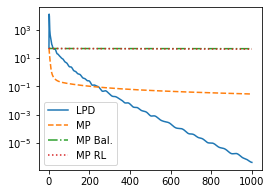

In [23]:
plt.semilogy(output_pd['k_list'], output_pd['gap'], '-', label='LPD')
plt.semilogy(output_mp['k_list'], output_mp['gap'], '--', label='MP')
plt.semilogy(output_mpbal['k_list'], output_mpbal['gap'], '-.', label='MP Bal.')
plt.semilogy(output_mp_rellip['k_list'], output_mp_rellip['gap'], ':', label='MP RL')

kappa_opt = (
  ((prob.Lx-prob.mux)/prob.mux)**0.5 +
  prob.Lxy/((prob.mux*prob.muy)**0.5) +
  ((prob.Ly-prob.muy)/prob.muy)**0.5
)
kappa_mp = (
  ((prob.Lx-prob.mux)/prob.mux) +
  prob.Lxy/min(prob.mux,prob.muy) +
  ((prob.Ly-prob.muy)/prob.muy)
)
kappa_rellip = (
  ((prob.Lx-prob.mux)/prob.mux) +
  prob.Lxy/((prob.mux*prob.muy)**0.5) +
  ((prob.Ly-prob.muy)/prob.muy)
)

print(f'Lxy={prob.Lxy}, Lx={prob.Lx}, Ly={prob.Ly}, ' 
      f'mux={prob.mux}, muy={prob.muy}, ' 
      f'sqrt(mux*muy)={(prob.mux*prob.muy)**0.5}, '
      f'kappa_opt={kappa_opt}, kappa_mp={kappa_mp}, kappa_rellip={kappa_rellip}')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(4, 3)

plt.legend()
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
plotname = f'RLPolicyEval_d200_vs_k_{timestamp}'
plt.savefig(f'{plotname}.pdf', bbox_inches='tight')
plt.savefig(f'{plotname}.png', bbox_inches='tight')
plt.show()
plt.show()

# RL Policy Evaluation Bi-SC-C Problem (d=300, rho=1.0): primal-dual gap vs iteration (k)

In [11]:
d = 300

rho = 1.0
B = rho*np.eye(C.shape[0])

D = 1000.0

def proj(x):
    if utils.l2_norm(x) < D:
        return x
    else:
        return x/utils.l2_norm(x)

proj_x = proj
proj_y = proj

x_0 = np.random.randn(d)
y_0 = np.random.randn(d)

prob = probs.QuadraticSeparableMinimaxProb(
    A=-A, B=B, C=C, b=None, c=-b.squeeze(), 
    proj_x=proj_x, proj_y=proj_y)

prob.muyy = prob.muy = 0.0
output_pd = algos.primalDualSeparable_optimize(
  prob, K=10000, z_0=(x_0, y_0),
  log_freq=1, log_prefix='PD', print_freq=10000)

output_mp = algos.MirrorProx_optimize(
  prob, K=10000, z_0=(x_0, y_0),
  log_freq=1, log_prefix='MP', print_freq=10000)

/home/kiran/codes/minimax_opt/smooth_minimax_github_optimal_primal_dual_cameraready/minmax/algos/primal_dual.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  kappa_y = (-1+prob.Ly/prob.muy)


PDk=0,x_k=[-0.11003072  0.49081806  1.91159711],y_k=[-0.25433333  0.42501499  0.42585299];gap=62,|grad|=17,func=54;
MPk=0,x_k=[-0.11003072  0.49081806  1.91159711],y_k=[-0.25433333  0.42501499  0.42585299];gap=62,|grad|=17,func=54;avg:gap=62,|grad|=17,func=54;tgap=18,|grad|=8.5,func=12;tavg:gap=18,|grad|=8.5,func=12


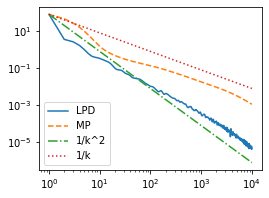

In [22]:
plt.loglog(output_pd['k_list'], output_pd['gap'], '-', label='LPD')
plt.loglog(output_mp['k_list'], output_mp['gap'], '--', label='MP')
 
plt.loglog(output_mp['k_list'], output_pd['gap'][0]/(np.array(output_mp['k_list'])**2), '-.', label='1/k^2')
plt.loglog(output_mp['k_list'], output_mp['gap'][0]/np.array(output_mp['k_list']), ':', label='1/k')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(4, 3)

plt.legend()
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
plotname = f'RLPolicyEval_d300_vs_k_{timestamp}'
plt.savefig(f'{plotname}.pdf', bbox_inches='tight')
plt.savefig(f'{plotname}.png', bbox_inches='tight')
plt.show()
plt.show()